## Harshal Dupare | 18MA20015 

colab view link : https://drive.google.com/file/d/1Q3Ljbjk7N8TZD3Dq1XKWQoRbwV0uFB0-/view?usp=sharing

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [2]:
import numpy as np
from time import time
import torch
import torch.nn as nn
import torch.functional as F
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms,datasets
from torch import nn, optim
from tqdm.notebook import tqdm

1. Build a neural network with given description. (only feed forward part, no backpropagation)
    * No. of hidden layers = 1
    * No. of neurons in the hidden layer1 = 100
    * Activation function of hidden layer: Sigmoid function
    * No. of neurons in the output layer = 10
    * Activation function in output layer: SoftMax function
    * Input: MNIST data (28*28)

In [3]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN,self).__init__()
        
        # fully connected layers
        self.fcon1 = nn.Linear(28*28,100)
        self.fcon2 = nn.Linear(100,10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.fcon1(x)
        x = self.sigmoid(x)
        x = self.fcon2(x)
        
        # probs
        x = self.softmax(x)
        return x

In [18]:
class Pipeline:
  def __init__(self,Model):
    self.model = Model()
    self.LR_decay = False
    self.lr_from = 1e-1
    self.lr_to = 1e-3

  def load_data(self,batch_size=256,image_size=28):
    self.batch_size = batch_size
    transform_data = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])

    try:
      train_data = datasets.MNIST(root='./data',train=True,download=False,transform = transform_data)
    except:
      train_data = datasets.MNIST(root='./data',train=True,download=True,transform = transform_data)
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4)

    test_data = datasets.MNIST(root='./data',train=False,download=False,transform = transform_data)
    testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=4)

    return trainloader,testloader

  def train(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
    # training the model

    if self.LR_decay:
      lr_decay_step = (self.lr_from - self.lr_to)/(N_epoch)
    else:
      lr_decay_step = 0.0

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in tqdm(range(N_epoch)):
        epoch_loss = 0.0
        correct_count = 0
        sample_count = 0
        Optimizer.zero_grad()
        i = 0
        # on Traning Data
        for (X_i,y_i) in Trainloader:
            if using_gpu:
                X_i,y_i=X_i.cuda(),y_i.cuda()
            
            output=self.model(X_i)
            
            y_i_pred = torch.argmax(output,dim=1)
            
            loss = Criterion(output,y_i)
            
            epoch_loss+=loss
            
            correct_count +=torch.sum(y_i==y_i_pred)
            sample_count+=len(y_i)
            i+=1

        tepoch_loss = 0.0
        tcorrect_count = 0
        tsample_count = 0
        ti = 0
        
        # on Testing Data
        for (tX_i,ty_i) in Testloader:
            if using_gpu:
                tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
            
            toutput=self.model(tX_i)
            
            ty_i_pred = torch.argmax(toutput,dim=1)
            
            tloss = Criterion(toutput,ty_i)
            
            tepoch_loss+=tloss
            
            tcorrect_count +=torch.sum(ty_i==ty_i_pred)
            tsample_count+=len(ty_i)
            ti+=1

        epoch_loss=epoch_loss/(i)
        tepoch_loss=tepoch_loss/(ti)
        
        epoch_loss.backward()
        
        Optimizer.step()
        
        if self.LR_decay:
          for param_group in Optimizer.param_groups:
            param_group['lr'] = param_group['lr']-lr_decay_step
        
        train_loss.append(epoch_loss.item())
        train_acc.append(100*correct_count.item()/sample_count)
        test_loss.append(tepoch_loss.item())
        test_acc.append(100*tcorrect_count.item()/tsample_count)
        if print_epoch_details:
          print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
    
    fig = plt.figure(figsize=[20,8]) 
    plt.subplot(121)
    plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
    plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(122)
    plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
    plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
    plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')

  def train_mini_batch(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
      # training the model

      if self.LR_decay:
        lr_decay_step = (self.lr_from - self.lr_to)/(N_epoch)
      else:
        lr_decay_step = 0.0

      train_loss = []
      train_acc = []
      mtrain_loss = []
      mtrain_acc = []
      test_loss = []
      test_acc = []
      for epoch in tqdm(range(N_epoch)):
          epoch_loss = 0.0
          correct_count = 0
          sample_count = 0
          i = 0
          
          # on Traning Data
          for (X_i,y_i) in Trainloader:
              if using_gpu:
                  X_i,y_i=X_i.cuda(),y_i.cuda()

              output=self.model(X_i)
              
              y_i_pred = torch.argmax(output,dim=1)
              
              loss = Criterion(output,y_i)
              mtrain_loss.append(loss.item())

              Optimizer.zero_grad()
              loss.backward()
              Optimizer.step()
              
              epoch_loss+=loss
              
              correct_count +=torch.sum(y_i==y_i_pred)
              sample_count+=len(y_i)
              mtrain_loss.append(loss.item())
              mtrain_acc.append(float(torch.sum(y_i==y_i_pred)/len(y_i))*100)

              i+=1

          tepoch_loss = 0.0
          tcorrect_count = 0
          tsample_count = 0
          ti = 0
          
          # on Testing Data
          for (tX_i,ty_i) in Testloader:
              if using_gpu:
                  tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
              
              toutput=self.model(tX_i)
              
              ty_i_pred = torch.argmax(toutput,dim=1)
              
              tloss = Criterion(toutput,ty_i)
              
              tepoch_loss+=tloss
              
              tcorrect_count +=torch.sum(ty_i==ty_i_pred)
              tsample_count+=len(ty_i)
              ti+=1

          epoch_loss=epoch_loss/(i)
          tepoch_loss=tepoch_loss/(ti)

          if self.LR_decay:
            for param_group in Optimizer.param_groups:
              param_group['lr'] = param_group['lr']-lr_decay_step
          
          train_loss.append(epoch_loss.item())
          train_acc.append(100*correct_count.item()/sample_count)
          test_loss.append(tepoch_loss.item())
          test_acc.append(100*tcorrect_count.item()/tsample_count)
          if print_epoch_details:
            print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
      
      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
      plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.subplot(122)
      plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
      plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      print(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}")
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')
      plt.show()

      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(len(mtrain_loss)),mtrain_loss,'g-',label='Mini Batch Training Loss')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Loss')
      plt.legend(loc='upper right')
      plt.subplot(122)
      plt.plot(range(len(mtrain_acc)),mtrain_acc,'g-',label='Mini Batch Training Accuracy')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Accuracy')
      plt.legend(loc='upper right')
      plt.show()


Training using GPU: True


Epoch 1/50 : Training loss: 2.3033 | Training Accuracy: 10.52 | Testing loss: 2.3025 | Testing Accuracy: 10.38 
Epoch 2/50 : Training loss: 2.3033 | Training Accuracy: 10.52 | Testing loss: 2.3031 | Testing Accuracy: 10.38 
Epoch 3/50 : Training loss: 2.3032 | Training Accuracy: 10.52 | Testing loss: 2.3027 | Testing Accuracy: 10.38 
Epoch 4/50 : Training loss: 2.3033 | Training Accuracy: 10.52 | Testing loss: 2.3026 | Testing Accuracy: 10.38 
Epoch 5/50 : Training loss: 2.3033 | Training Accuracy: 10.53 | Testing loss: 2.3028 | Testing Accuracy: 10.38 
Epoch 6/50 : Training loss: 2.3033 | Training Accuracy: 10.53 | Testing loss: 2.3031 | Testing Accuracy: 10.38 
Epoch 7/50 : Training loss: 2.3032 | Training Accuracy: 10.53 | Testing loss: 2.3032 | Testing Accuracy: 10.39 
Epoch 8/50 : Training loss: 2.3032 | Training Accuracy: 10.53 | Testing loss: 2.3027 | Testing Accuracy: 10.39 
Epoch 9/50 : Training loss: 2.3033 | Training Accuracy: 10.54 | Testing loss: 2.3027 | Testing Accuracy:

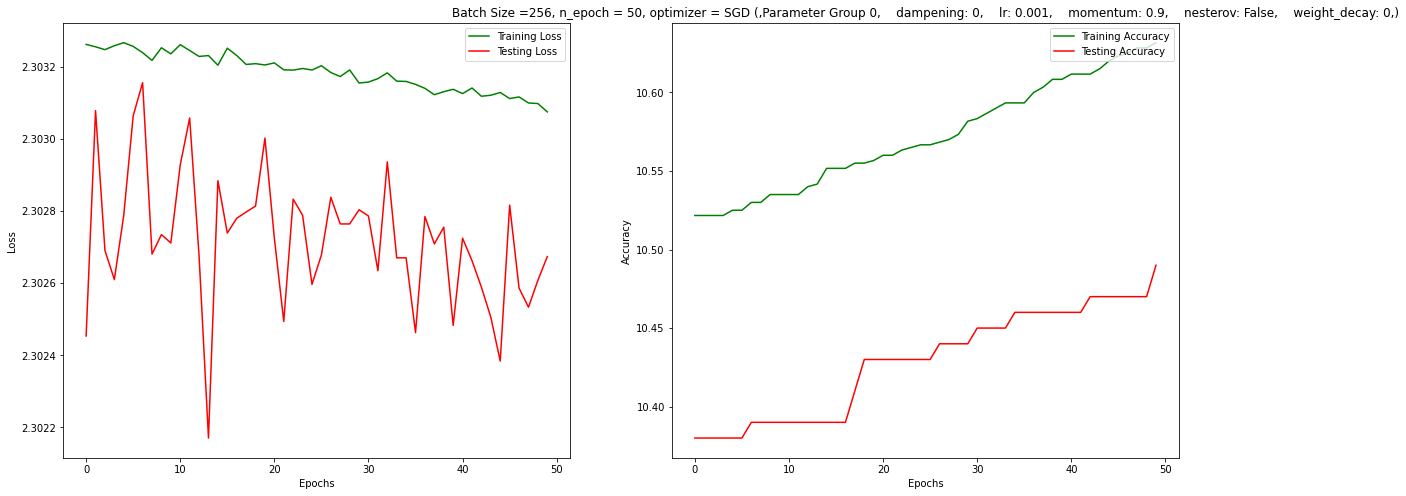

In [10]:
batch_size = 256
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum,)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

## Problem in using SGD so we can either increase the number of epoch by 10 or 100 times OR change to mini batch OR use Adam

Refer: https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing

Training using GPU: True


Epoch 1/50 : Training loss: 2.3023 | Training Accuracy: 9.89 | Testing loss: 2.3021 | Testing Accuracy: 9.85 
Epoch 2/50 : Training loss: 2.3014 | Training Accuracy: 12.00 | Testing loss: 2.3012 | Testing Accuracy: 14.93 
Epoch 3/50 : Training loss: 2.3005 | Training Accuracy: 19.18 | Testing loss: 2.3003 | Testing Accuracy: 20.90 
Epoch 4/50 : Training loss: 2.2996 | Training Accuracy: 26.96 | Testing loss: 2.2991 | Testing Accuracy: 30.67 
Epoch 5/50 : Training loss: 2.2986 | Training Accuracy: 23.52 | Testing loss: 2.2983 | Testing Accuracy: 19.19 
Epoch 6/50 : Training loss: 2.2976 | Training Accuracy: 14.36 | Testing loss: 2.2969 | Testing Accuracy: 12.82 
Epoch 7/50 : Training loss: 2.2965 | Training Accuracy: 11.87 | Testing loss: 2.2956 | Testing Accuracy: 11.80 
Epoch 8/50 : Training loss: 2.2953 | Training Accuracy: 11.64 | Testing loss: 2.2946 | Testing Accuracy: 11.72 
Epoch 9/50 : Training loss: 2.2940 | Training Accuracy: 11.69 | Testing loss: 2.2934 | Testing Accuracy: 1

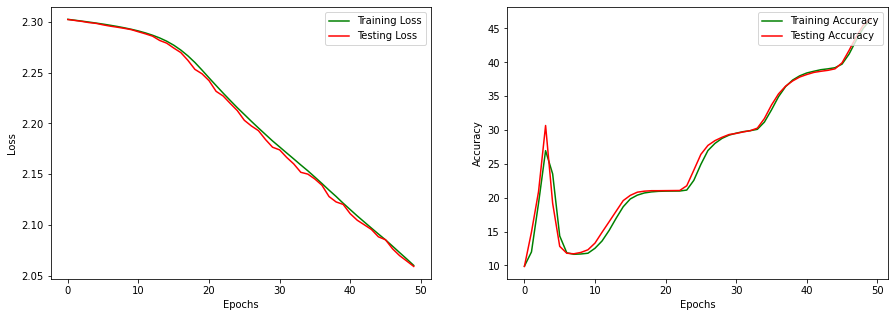

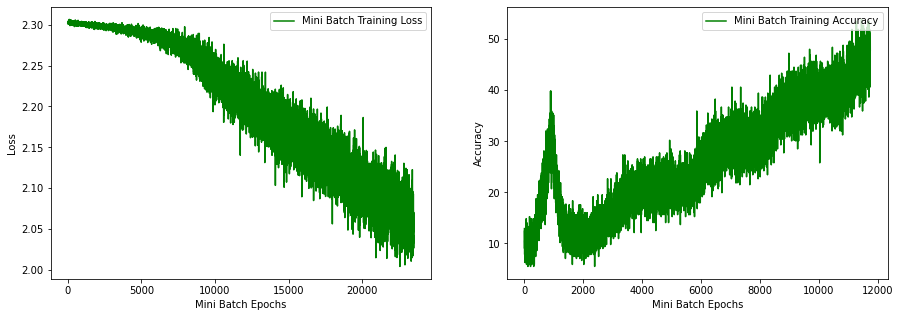

In [12]:
# using mini batch

batch_size = 256
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum,)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

Training using GPU: True


Epoch 1/50 : Training loss: 2.3018 | Training Accuracy: 13.23 | Testing loss: 2.3016 | Testing Accuracy: 13.37 
Epoch 2/50 : Training loss: 2.2991 | Training Accuracy: 19.91 | Testing loss: 2.2988 | Testing Accuracy: 20.05 
Epoch 3/50 : Training loss: 2.2962 | Training Accuracy: 20.55 | Testing loss: 2.2960 | Testing Accuracy: 20.80 
Epoch 4/50 : Training loss: 2.2932 | Training Accuracy: 20.89 | Testing loss: 2.2931 | Testing Accuracy: 21.10 
Epoch 5/50 : Training loss: 2.2901 | Training Accuracy: 21.25 | Testing loss: 2.2899 | Testing Accuracy: 21.40 
Epoch 6/50 : Training loss: 2.2868 | Training Accuracy: 22.12 | Testing loss: 2.2869 | Testing Accuracy: 22.20 
Epoch 7/50 : Training loss: 2.2833 | Training Accuracy: 23.38 | Testing loss: 2.2832 | Testing Accuracy: 23.52 
Epoch 8/50 : Training loss: 2.2797 | Training Accuracy: 24.55 | Testing loss: 2.2791 | Testing Accuracy: 24.80 
Epoch 9/50 : Training loss: 2.2758 | Training Accuracy: 25.58 | Testing loss: 2.2753 | Testing Accuracy:

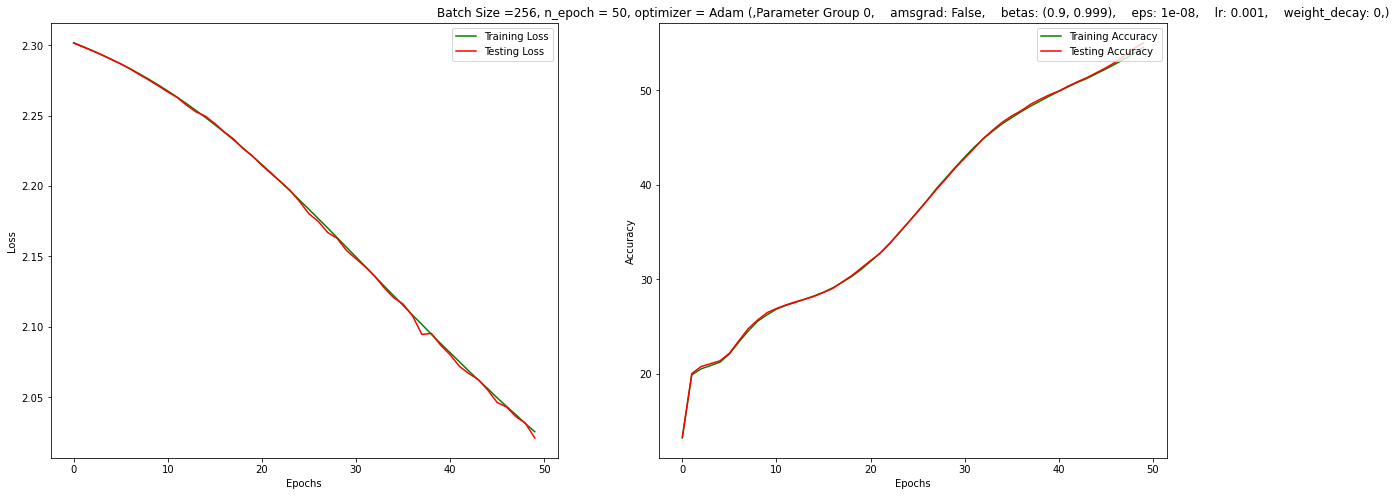

In [14]:
# using Adam

batch_size = 256
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

# optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum,)
optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train(trainloader,testloader,criterion,optimizer_adam,n_epoch)

# Varying Batch Size and Learning Rate

* FCNN needs more epoch to learn with more accuracy

In [17]:
# using SGD with mini batch

LR_list = [0.5,0.2,0.1,0.05,0.025] # learning rate list
BS_list = [32,64,128,256,1024] # batch size list

for batch_size in tqdm(BS_list):
  for learning_rate in tqdm(LR_list):
    momentum = 0.0

    criterion = nn.CrossEntropyLoss()
    pl = Pipeline(FCNN)

    trainloader,testloader = pl.load_data(batch_size)

    using_gpu = torch.cuda.is_available()
    if using_gpu:
        pl.model = pl.model.cuda()
        criterion = criterion.cuda()
    print("Training using GPU:",using_gpu)

    optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
    # optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)
    print(f"Batch Size : {batch_size}, Learning Rate : {learning_rate}")
    n_epoch = 50
    pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch,False)

Output hidden; open in https://colab.research.google.com to view.

## 6.a

* Observe that as we decrease the batch size the final accuracy reached increase as due to getting more training events
* Observe that as the batch size increases the mini batch learning curve becomes more smooth

## 6.b Observations

### For a specific Batch Size -

* Observe that as we decrease the Learning rate it takes longer and longer to reach the same level of loss ( or accuracy )
* Observe that for larger learning rates the loss ( or accuracy) curve ( mainly see the mini batch curve ) is much smoother( less varying ) see for eg. 0.5 and 0.05.
* Observe that there are less sudden changes in the accuracy ( loss ) curve ( mainly tarining epoch curve ) this maybe due to small learning rate may get go through small local minima which is not global minima whereas large learning rate may jump over it
* **So for this problem it seems best to have large enough learning rate at the start and slowly reduce it as we reach a local minima as to reach even less loss which is only possible if learning rate is small enough to allow the parameters to reach optimal parameter more accurately**

# Varying Learning rate along with epoch

Training using GPU: True


Epoch 1/50 : Training loss: 2.2987 | Training Accuracy: 16.52 | Testing loss: 2.2922 | Testing Accuracy: 18.02 
Epoch 2/50 : Training loss: 2.2751 | Training Accuracy: 20.27 | Testing loss: 2.2440 | Testing Accuracy: 21.05 
Epoch 3/50 : Training loss: 2.2185 | Training Accuracy: 21.00 | Testing loss: 2.1922 | Testing Accuracy: 21.12 
Epoch 4/50 : Training loss: 2.1741 | Training Accuracy: 25.92 | Testing loss: 2.1555 | Testing Accuracy: 30.24 
Epoch 5/50 : Training loss: 2.1358 | Training Accuracy: 34.41 | Testing loss: 2.1079 | Testing Accuracy: 38.39 
Epoch 6/50 : Training loss: 2.0895 | Training Accuracy: 39.17 | Testing loss: 2.0665 | Testing Accuracy: 40.31 
Epoch 7/50 : Training loss: 2.0428 | Training Accuracy: 44.60 | Testing loss: 2.0125 | Testing Accuracy: 51.01 
Epoch 8/50 : Training loss: 1.9929 | Training Accuracy: 53.70 | Testing loss: 1.9669 | Testing Accuracy: 55.80 
Epoch 9/50 : Training loss: 1.9492 | Training Accuracy: 56.10 | Testing loss: 1.9272 | Testing Accuracy:

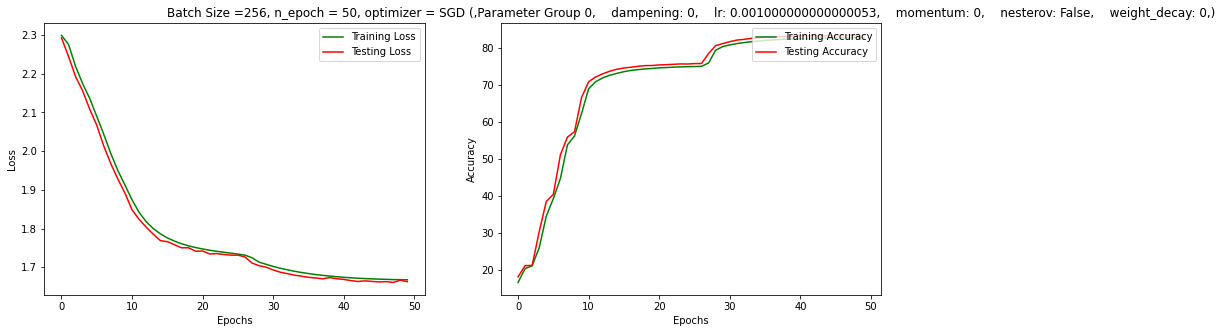

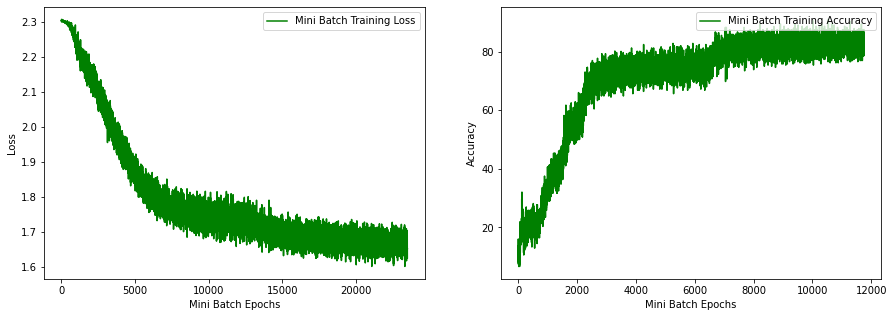

In [20]:
# Varying LR

batch_size = 256
learning_rate = 1e-1
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)
pl.LR_decay = True

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

Training using GPU: True


Epoch 1/50 : Training loss: 2.2982 | Training Accuracy: 12.32 | Testing loss: 2.2924 | Testing Accuracy: 11.35 
Epoch 2/50 : Training loss: 2.2826 | Training Accuracy: 12.37 | Testing loss: 2.2652 | Testing Accuracy: 17.01 
Epoch 3/50 : Training loss: 2.2306 | Training Accuracy: 23.09 | Testing loss: 2.1882 | Testing Accuracy: 30.64 
Epoch 4/50 : Training loss: 2.1502 | Training Accuracy: 36.58 | Testing loss: 2.1109 | Testing Accuracy: 39.26 
Epoch 5/50 : Training loss: 2.0899 | Training Accuracy: 39.53 | Testing loss: 2.0667 | Testing Accuracy: 39.98 
Epoch 6/50 : Training loss: 2.0451 | Training Accuracy: 45.42 | Testing loss: 2.0172 | Testing Accuracy: 48.09 
Epoch 7/50 : Training loss: 2.0004 | Training Accuracy: 48.90 | Testing loss: 1.9781 | Testing Accuracy: 52.30 
Epoch 8/50 : Training loss: 1.9638 | Training Accuracy: 55.02 | Testing loss: 1.9478 | Testing Accuracy: 56.62 
Epoch 9/50 : Training loss: 1.9370 | Training Accuracy: 56.88 | Testing loss: 1.9223 | Testing Accuracy:

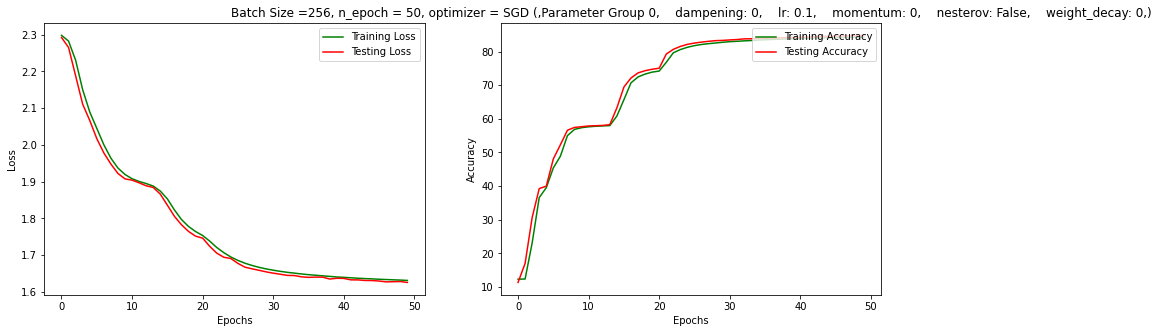

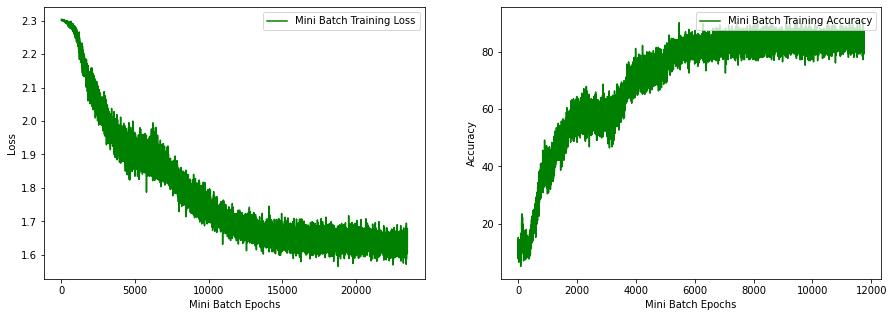

In [21]:
# Constant LR with max value 

batch_size = 256
learning_rate = 1e-1
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

Training using GPU: True


Epoch 1/50 : Training loss: 2.3026 | Training Accuracy: 8.82 | Testing loss: 2.3027 | Testing Accuracy: 8.68 
Epoch 2/50 : Training loss: 2.3025 | Training Accuracy: 8.87 | Testing loss: 2.3025 | Testing Accuracy: 8.78 
Epoch 3/50 : Training loss: 2.3025 | Training Accuracy: 9.01 | Testing loss: 2.3025 | Testing Accuracy: 8.96 
Epoch 4/50 : Training loss: 2.3024 | Training Accuracy: 9.12 | Testing loss: 2.3022 | Testing Accuracy: 9.06 
Epoch 5/50 : Training loss: 2.3023 | Training Accuracy: 9.18 | Testing loss: 2.3021 | Testing Accuracy: 9.13 
Epoch 6/50 : Training loss: 2.3022 | Training Accuracy: 9.27 | Testing loss: 2.3021 | Testing Accuracy: 9.16 
Epoch 7/50 : Training loss: 2.3021 | Training Accuracy: 9.33 | Testing loss: 2.3021 | Testing Accuracy: 9.24 
Epoch 8/50 : Training loss: 2.3020 | Training Accuracy: 9.42 | Testing loss: 2.3020 | Testing Accuracy: 9.29 
Epoch 9/50 : Training loss: 2.3020 | Training Accuracy: 9.48 | Testing loss: 2.3020 | Testing Accuracy: 9.34 
Epoch 10/5

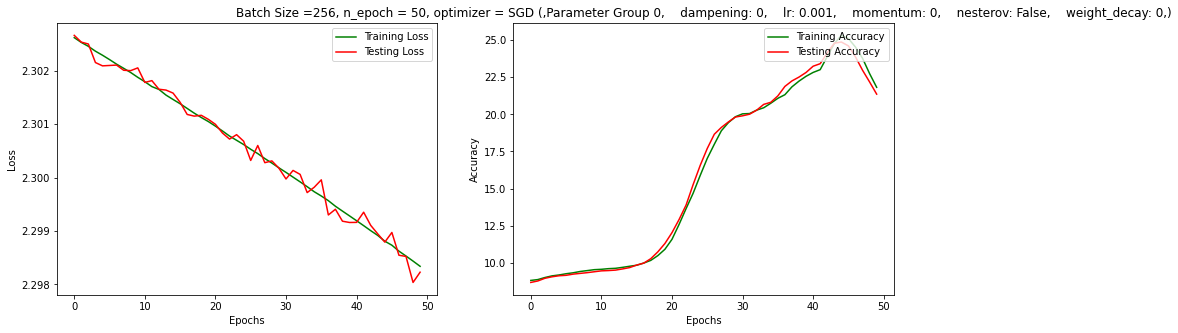

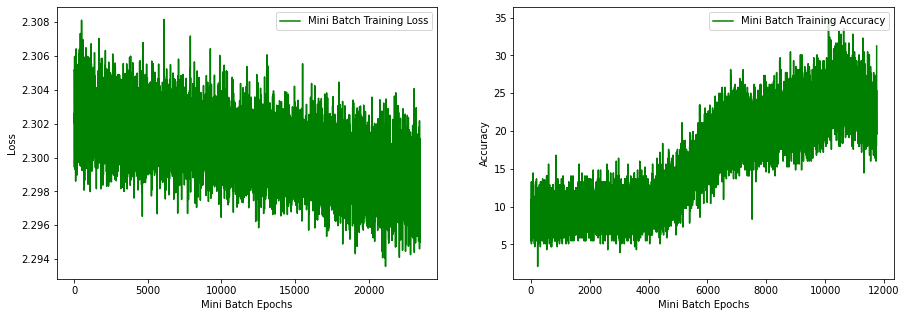

In [22]:
# Constant LR with min value 

batch_size = 256
learning_rate = 1e-3
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(FCNN)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

## 6.c Observations
* Observe that when er use the min of learning rate the convergens will take more number of epoch as the step size towards the optima are small
* When we use the varying ( here we implemented linear varying ) learning rate we reach the optima value with less sudden changes compared to the max learning rate, hence this methods seems more stable and also as fast.